In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/lille/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [ ]:
# Configuration
SEASON = '1920'
MIN_MINUTES = 800

# COLORES DE LA PALETA TEAM_COLORS (más cercanos a colores oficiales)
LILLE_COLORS = {
    'primary': '#DC143C',    # Crimson (parecido al rojo Lille #DA291C)
    'secondary': '#000000'   # Black
}

GENT_COLORS = {
    'primary': '#004D98',    # Navy Blue (parecido al azul Gent #0033A0)
    'secondary': '#FFFFFF'   # White
}

FW_PLAYERS = [
    {'name': 'Victor Osimhen', 'search': 'Osimhen', 'pos': 'FW', 'team': 'Lille', 'table': 'domestic'},
    {'name': 'Jonathan David', 'search': 'Jonathan David', 'pos': 'FW', 'team': 'Gent', 'table': 'extras'},
]

SAVE_PATH_BASE = "./osimhen_david_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [ ]:
# Conexión BD - Combinar domestic + extras para season 1920
db = get_db_manager()

# Query domestic (Big 5 - Osimhen en Lille)
query_domestic = text("""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics,
    'domestic' as source_table
FROM footballdecoded.players_domestic p
WHERE p.season = :season
""")

# Query extras (Liga Belga - David en Gent)
query_extras = text("""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics,
    'extras' as source_table
FROM footballdecoded.players_extras p
WHERE p.season = :season
""")

with db.engine.connect() as conn:
    df_domestic = pd.read_sql(query_domestic, conn, params={'season': SEASON})
    df_extras = pd.read_sql(query_extras, conn, params={'season': SEASON})

# Combinar ambas tablas
df_raw = pd.concat([df_domestic, df_extras], ignore_index=True)

db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
print(f"  Domestic: {df_domestic.shape[0]} | Extras: {df_extras.shape[0]}")
df_raw.head()

2026-01-12 13:02:19,957 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-12 13:02:20,122 - database.connection - INFO - Database connection successful


Extraídos: 4124 registros, 11 columnas
  Domestic: 2655 | Extras: 1469


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics,source_table
0,793e3ebe2c9d739a,Ji Dong-won,Mainz 05,GER-Bundesliga,1920,"FW,MF",KOR,28.0,"{'CS': '4', 'FK': '0', 'OG': '0', '/90': '-0.4...","{'understat_xa': '0.0', 'understat_team': 'Mai...",domestic
1,03e7edebbab0f231,Fyodor Smolov,Celta Vigo,ESP-La Liga,1920,FW,RUS,29.0,"{'FK': '0', 'OG': '0', 'Crs': '6', 'Fld': '7',...","{'understat_xa': '0.1859359983354807', 'unders...",domestic
2,6d075924f1893476,Alejandro Pozo Pozo,Mallorca,ESP-La Liga,1920,DF,ESP,20.0,"{'FK': '0', 'OG': '0', 'Crs': '70', 'Fld': '17...","{'understat_xa': '1.3864480946213007', 'unders...",domestic
3,d72d28e43b75dbf9,Fabricio,Mallorca,ESP-La Liga,1920,GK,ESP,31.0,"{'CS': '0', 'FK': '0', 'OG': '0', '/90': '-0.7...",{},domestic
4,add8c8624f2413f6,Javier Muñoz,Alavés,ESP-La Liga,1920,"FW,MF",ESP,24.0,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '0',...","{'understat_xa': '0.0', 'understat_team': 'Ala...",domestic


In [ ]:
# Filtrar por minutos mínimos Y posición FW
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('FW', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + FW: {df_filtered.shape[0]} jugadores")
print(f"\nLigas incluidas:")
print(df_filtered['league'].value_counts())

Filtro 800+ min + FW: 757 jugadores

Ligas incluidas:
league
ENG-Premier League    103
POR-Primeira Liga     103
ESP-La Liga           101
GER-Bundesliga        100
FRA-Ligue 1            99
ITA-Serie A            94
NED-Eredivisie         83
BEL-Pro League         74
Name: count, dtype: int64


In [ ]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [ ]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [ ]:
# Métricas a excluir de normalización
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id', 
    'CS%', 'CS', 'PSxG+/-', 'PSxG', 'Save_Save%',
    "Sweeper_#OPA", 'Sweeper_#OPA/90', 'Sweeper_AvgDist', "Goal Kicks_Launch%", 'G-xG'
}

# Calcular per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Calcular per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 144 + 7


In [ ]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 346
Percentiles totales: 346


In [ ]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 757 filas, 698 columnas
Limpieza completada: 696 columnas finales


In [ ]:
# Search FW players
player_ids = {}

print("FORWARD PLAYER SEARCH:")
print("=" * 50)

for player_config in FW_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

FORWARD PLAYER SEARCH:

Victor Osimhen - search: 'Osimhen':
  33e635289747ff6e - Victor Osimhen (Lille, FRA-Ligue 1, FW) - 2287.0 min
  ✓ ASSIGNED: Victor Osimhen -> 33e635289747ff6e

Jonathan David - search: 'Jonathan David':
  5988b6b8ef63203f - Jonathan David (Gent, BEL-Pro League, FW,MF) - 2095.0 min
  ✓ ASSIGNED: Jonathan David -> 5988b6b8ef63203f

PLAYERS FOUND:
  Victor Osimhen: 33e635289747ff6e
  Jonathan David: 5988b6b8ef63203f

✓ ALL PLAYERS FOUND


In [ ]:
# FW Centro metrics configuration
fw_metrics = [
    'expected_goals_per100touches', 'goals_per100touches', 'shots_per100touches', 'Touches_Att Pen_per100touches',
    'expected_assists_per100touches', 'Take-Ons_Succ_per100touches', 'npxG/Sh', 'G-xG',
    'Fld_per100touches', 'SCA_SCA90'
]
fw_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Touches in Box',
    'Expected Assists', 'Dribbles', 'npxG per Shot', 'Goals - xG',
    'Fouls Drawn', 'Shot Creating Actions'
]

METRICS_BY_POSITION = {
    'fw_st': {'metrics': fw_metrics, 'titles': fw_titles}
}

print("FW METRICS VERIFICATION:")
print("=" * 50)
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

FW METRICS VERIFICATION:
OK fw_st: 10 metrics, 10 titles


In [ ]:
# Osimhen vs David comparison configuration
COMPARISON = {
    'name': 'Osimhen_vs_David',
    'player1': 'Victor Osimhen',
    'player2': 'Jonathan David', 
    'position_type': 'FW_ST',
    'metrics_key': 'fw_st',
    'title': 'Victor Osimhen (Lille) vs Jonathan David (Gent) 19/20',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/osimhen.png', '/home/jaime/FD/data/blog/caras/tfm/david.png'],
    'colors': [LILLE_COLORS['primary'], GENT_COLORS['primary']]
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISON: Victor Osimhen (Lille) vs Jonathan David (Gent) 19/20

METRICS BY POSITION:
OK fw_st: 10 metrics, 10 titles


FW/ST PLAYER RADAR GENERATION

Processing: Victor Osimhen (Lille) vs Jonathan David (Gent) 19/20
  Dataset: 757 players (FW)
  Teams: Lille vs Gent
  Colors: ['#DA291C', '#0033A0']
  ✓ Completed: Osimhen_vs_David_combined.png


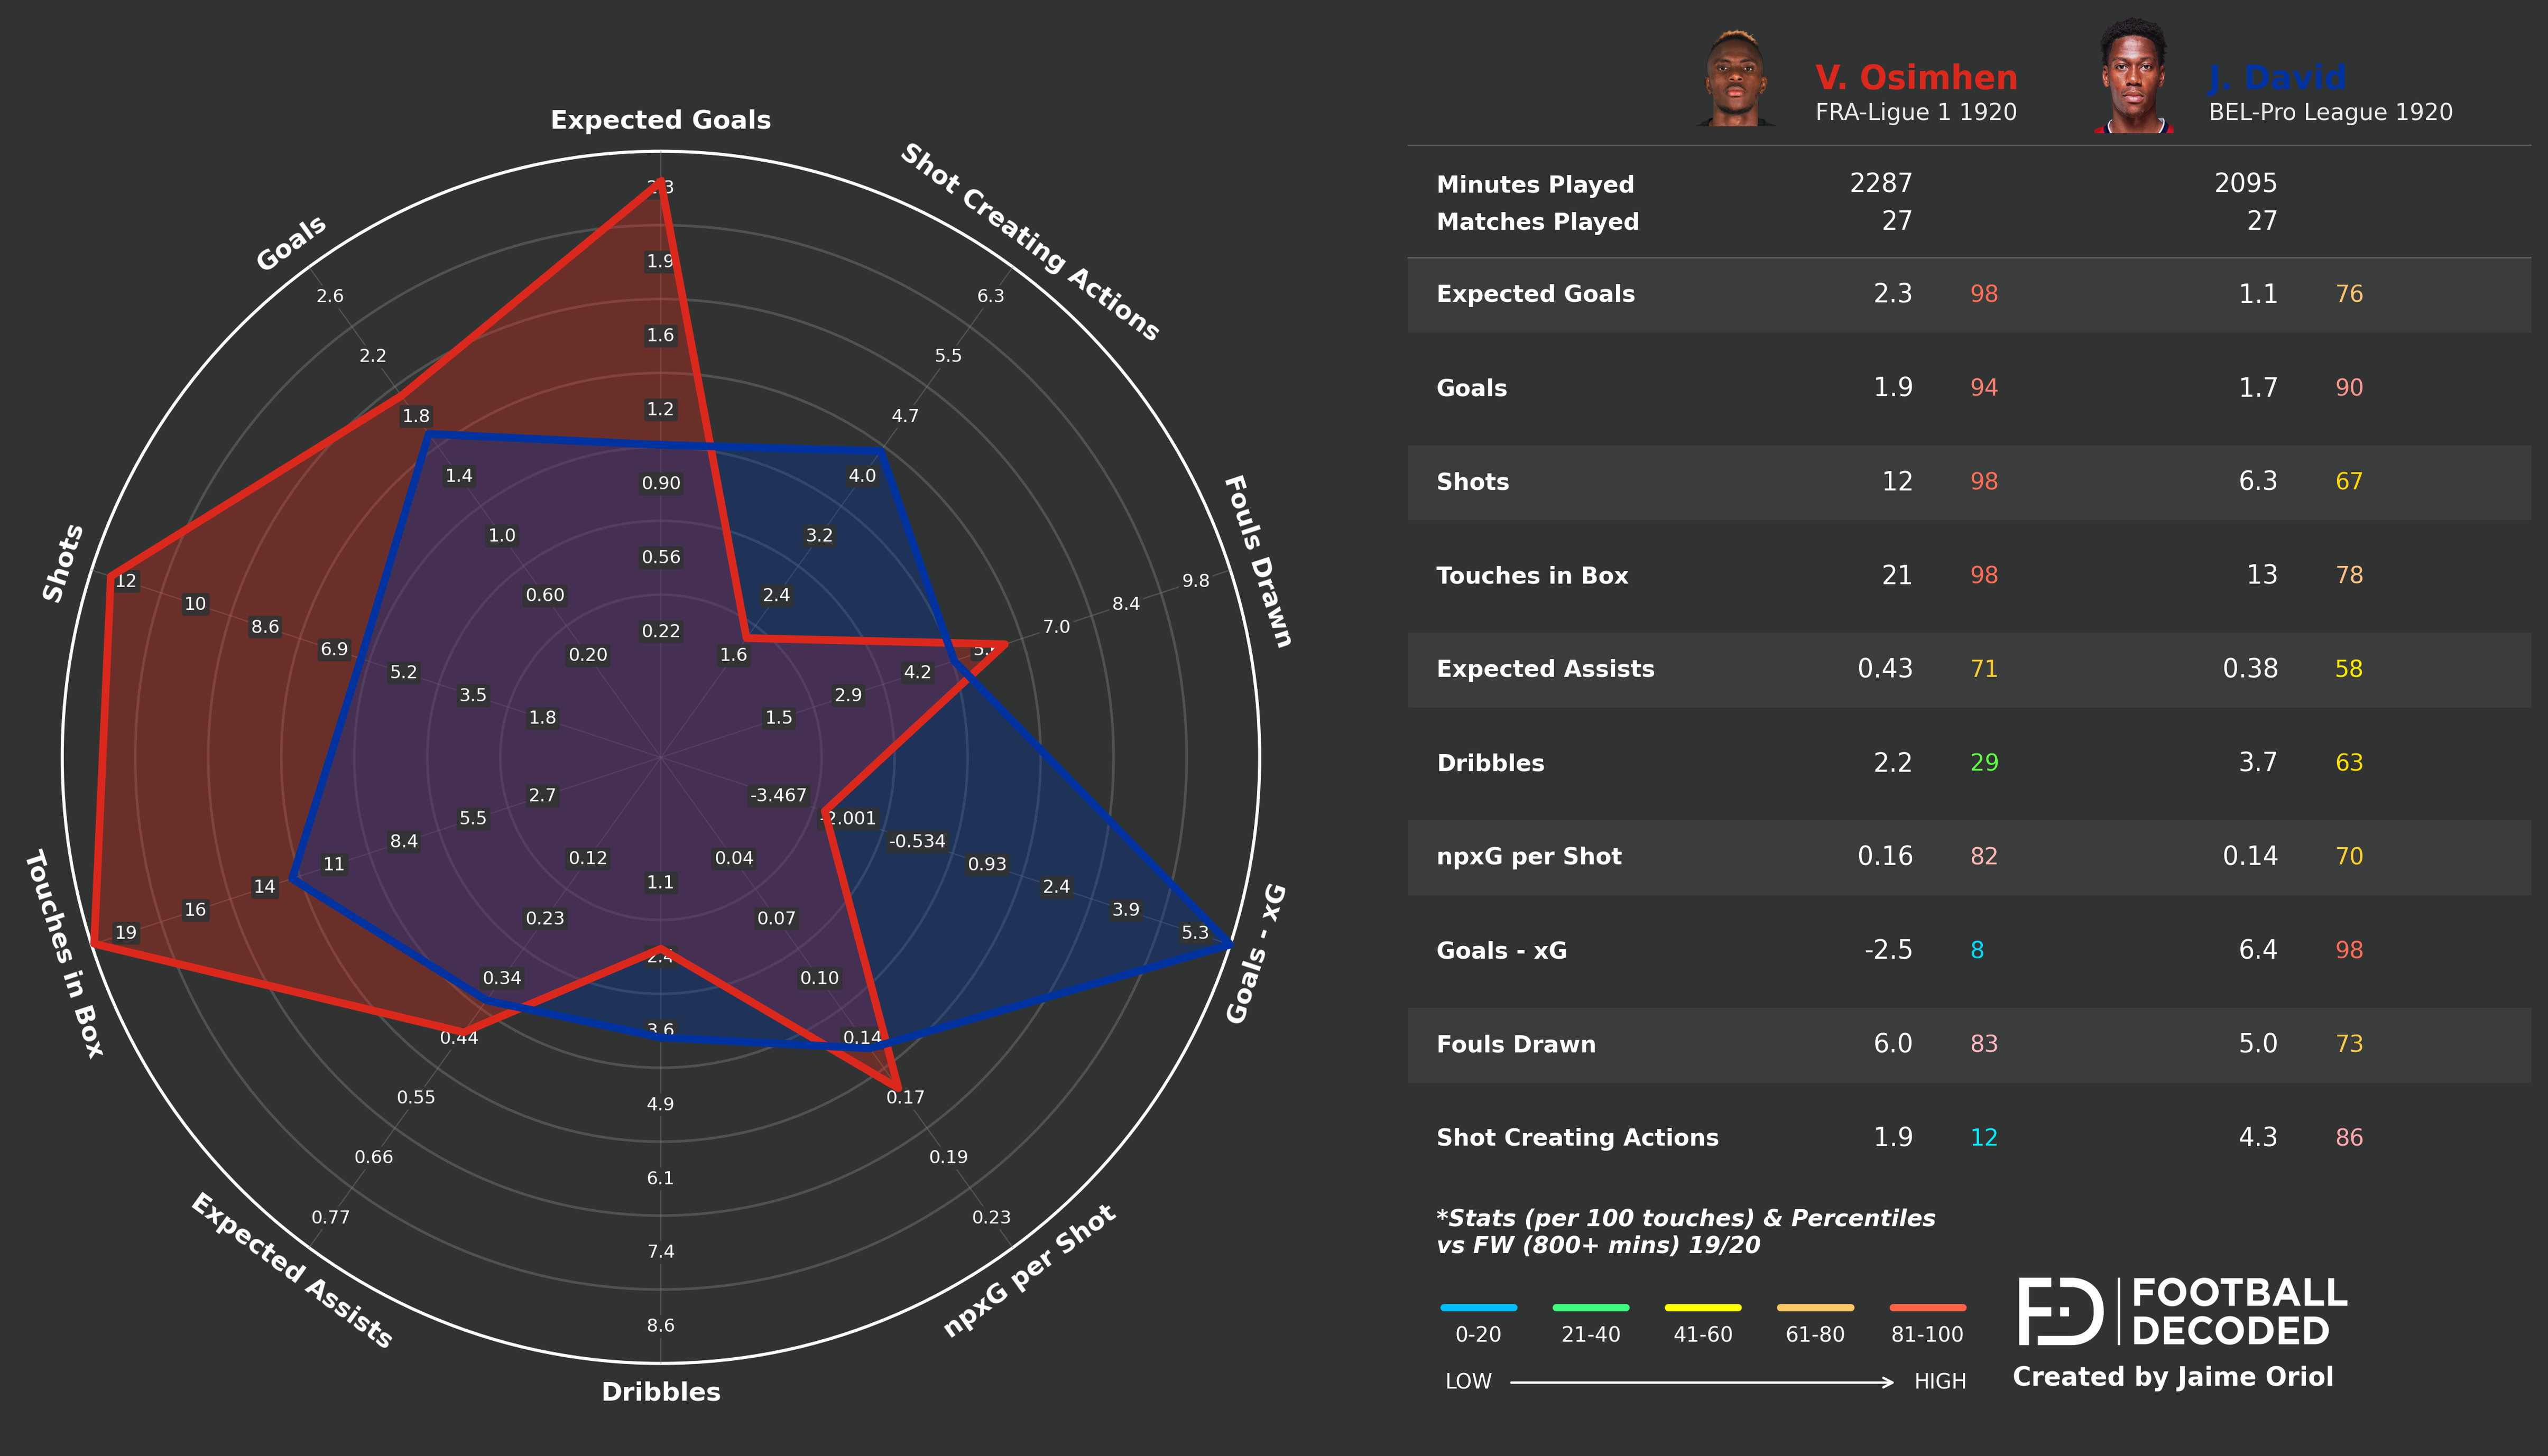


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./osimhen_david_radars/


In [ ]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("FW/ST PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset FW
    position_df = df_final[df_final['position'].str.contains('FW', case=False, na=False)].copy()
    position_filter = "FW"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 100 touches) & Percentiles\nvs {position_filter} ({MIN_MINUTES}+ mins) 19/20",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()